# 1. Introduction

**Silicon Valley** happens to be the most recent TV show that I have binged upon and I became a fan right off the bat. Everything from the content, plot, play etc appealed to me. 




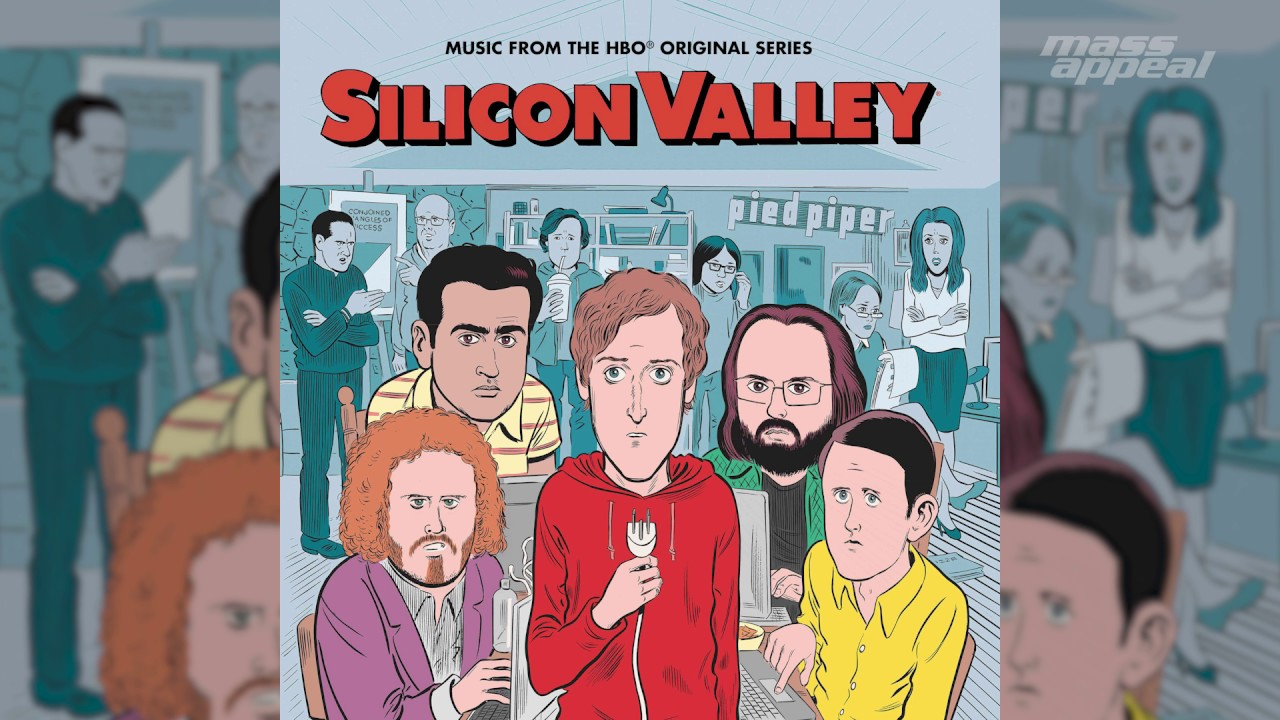








For those of you, who haven't seen the show , this is a journey of a group of techies trying to build something using their tech-ablilities. This group reminded me of a similar(yet very diffenernt) group of guys from another TV show called *The Bing Bang Theory (TBBT)* which was also a very popular seires. Personally, I hated TBBT (I'm sorry !) even though there is similar core theme to both the shows.  

So, in this project I have tried to use **Natural Language Processing(NLP)** to figure out how Silicon Valley is diffenent from TBBT and whether the language used has affected my preferences.

We'll try to answer the following questions : 

    1. What kind of langage is used in Silicon Valley ?
    2. What sentiment does Silicon Valley carry on Twitter ?
    3. Comparison between the languages of Silicon Valley and TBBT.

# 2. Data Collection and Data Cleaning

##  2.1 Data Collection

Our data is going to be transcripts of the show. Guys at  https://www.springfieldspringfield.co.uk/  have done a wonderful job in making transcripts for all the episodes. We will be using all the transcripts for the Season 1. (total 8 episodes so 8 transcripts).

In order to collect data we will be doing some web scraping using the Beautiful Soup package for parsing HTML and XML documents in python. 

[Beautiful Soup Documentation](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)

In [ ]:
#Importing packages

import requests
from bs4 import BeautifulSoup
import pickle
from requests import get

In [ ]:
#Creating a list of links to scrape

urls = []
for i in range(1,9):
    url = 'https://www.springfieldspringfield.co.uk/view_episode_scripts.php?tv-show=silicon-valley-2014&episode=s01e0'+str(i)
    urls.append(url)
    
urls

In [ ]:
#Perform scraping 

def url_to_transcript(url):
    page = requests.get(url).text
    soup = BeautifulSoup(page, "lxml")
    text = [soup.find('div','scrolling-script-container').text]
    print(url)
    return text

In [ ]:
#Storing all the transcripts in a list. This is the raw data on which we have to work. Very Unclean. Sigh ! 

transcripts = [url_to_transcript(u) for u in urls]
transcripts

In [ ]:
#Creating a list of episodes for easy reference

episodes  = []
for k in range(1,9):
    ep = 'e'+str(k)
    episodes.append(ep)
    
episodes

In [ ]:
#Creating a dictionary for easy readability (episode:transcript)

data_dict = {k:v for k,v in zip(episodes,transcripts)}
data_dict

## 2.2 Data Cleaning

Before cleaning our data, we will be storing it in a DataFrame since it's easier to manipulate in that format. We'll be making use of Pandas library for this purpose.<br> 
[Pandas Documentation](https://pandas.pydata.org/pandas-docs/stable/)

For string manipulation we will be making use of re(Regular expression) and string libraries. <br>
[re Documentation](https://docs.python.org/3/library/re.html)<br>
[String Documentation](https://docs.python.org/3/library/string.html)

In [ ]:
#Importing packages

import pandas as pd
import re
import string

In [ ]:
#Creating a dataframe

df = pd.DataFrame.from_dict(data_dict).transpose()
df.columns = ['transcripts']
df

In [ ]:
#Quick check of the dataframe to see if things look right

df.loc['e1', 'transcripts']

Data Cleaning can be a long process. However, as a first pass I will be performing the following steps in prder to clean the data : 
        1. Convert all text to lowercase
        2. Remove whitespace characters
        3. Remove punctuation marks
        4. Remove terms containing numbers

In [ ]:
# Making a function to peroform the above mentioned steps

def clean_text_pass1(text):
    text = text.lower()               
    text = re.sub('\s+',' ',text)     
    text = re.sub('[%s]' %re.escape(string.punctuation) , '', text)     
    text = re.sub('\w*\d\w*', '', text)                          
    return text
    

In [ ]:
# Checking if it works well

clean_text_pass1(df.loc['e1', 'transcripts'])

In [ ]:
#looks good. So we'll apply the function on our dataset

data = df.transcripts.apply(clean_text_pass1)
data

## 2.2.1 Organizing the data 

For analysis purpose we need our data to be arranged in two formats.
   1. **Corpus** - A collection of text
   2. **Document-Term Matrix** - Word count in matrix format

### Corpus

In [ ]:
#The clean dataframe created above is our corpus

data = pd.DataFrame(data) 
data                                         

### Document-Term Matrix

In order to create our Document-Term Matrix we will be using CountVectorizer module from scikit-Learn. This will help us in tokenizing the dataset and creating a matrix where each row represents a different document and each column represents a different word. The values in the matrix represent the number of times the word has appeared in the corresponding document. 

[CountVectorizer Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)


In [ ]:

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(data.transcripts)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data.index
data_dtm

## 3. Exploratory Data Analysis 

In this section, our aim is to get some insights about the dataset which we cleaned in the previous section. 

We will find the most common words and represent it using *matplotlib* and *wordclouds* modules to get an idea about the topics around which the conversation revolves in the show. Later on, we can do the same for TBBT and compare the difference in languages, if any. 

[Matplotlib Documentation](https://matplotlib.org/)<br>
[Word Cloud Documentation](https://amueller.github.io/word_cloud/)

In [ ]:
data_t = data_dtm.T
data_t.head()

In [ ]:
# Top 10 words in each episode


top_dict = {}
for c in data_t.columns:
    top = data_t[c].sort_values(ascending=False).head(10)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

We can see that there are a lot of top words are those words which are generally used in day-to-day conversation. These words will not be helpful in finding meaningful insights. So I have got rid of them using the text module of scikit-learn. There is already a list of such words called English_Stop_Words. To this list, we'd be adding the most common words found above. 

Further, we would also be getting rid of profanity since it's abundent in our transcripts and don't help in our analysis. 
To do so, I have downloaded a file containing bad_words made available by folks at CMU. [This is the list](https://www.cs.cmu.edu/~biglou/resources/)   Not for the faint of heart, though !!

In [ ]:
from sklearn.feature_extraction import text 

stop_words = text.ENGLISH_STOP_WORDS

In [ ]:
words = []
for item in stop_words:
    words.append(item)
    
len(words)

In [ ]:
# To above list of 318 words add the most common words.  
for episode in episodes:
    for t in top_dict[episode]:
        words.append(t[0])
        
len(words)

In [ ]:
# Reading the bad-words file

bad_words = pd.read_csv(r'E:\Silicon Valley\bad-words.txt')
type(bad_words)

In [ ]:
for item in bad_words.abbo:
    words.append(item)
    
len(words)

In [ ]:
# Now we have 1780 words  which need to be removed from our DTM 
# Recreate document-term matrix

cv = CountVectorizer(stop_words=words)
data_cv = cv.fit_transform(data.transcripts)
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_stop.index = data.index
data_stop

In [ ]:
#Importing dependancies and creating wordclouds for each episode

import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

fig = plt.figure(figsize = (15,5) )

for index , episode in enumerate(episodes):
    wordcloud = WordCloud(stopwords = words,max_font_size=50, background_color='white').generate(data.transcripts[episode])
    
    plt.subplot(2, 4, index+1)
    
    plt.imshow(wordcloud, interpolation="bilinear")
    
    plt.axis("off")
    plt.title(episode)
    
    
plt.show()


We see that some of the themes  areound which the  conversation revolves are - company, money, world, obsessed, vision, big etc. 
These words might be used by ambitious people trying to build something. Especially, in the tech industry. This is one of the reasons why I have been attracted to the show as I personally like to talk about these things too.  


Next up, lets's conduct a Sentiment Analysis on the tweets about the show and see what we can find. 

## 4.Sentiment Analysis 

In order to perform Sentiment Analysis we will be using tweepy module to collect tweets and textblob to perform analysis. 

[Tweepy Documentation](https://tweepy.readthedocs.io/en/latest/)<br>
[TextBlob Documentation](https://textblob.readthedocs.io/en/dev/)

In [ ]:
import tweepy
from textblob import TextBlob

access_token = '1133364060718678017-NlAtZqnmW1XQrHiFRFaSn2pkgg9bjN'
access_token_secret = 'nwRvtguHBdlAYESq417sIbOgUiiCioHWrwye2vLCIGcBZ'
consumer_key = 'Mup6xb3v5b3mL85kmESyU4BDC'
consumer_secret = 'nr1zsiK4Mazq8H677CPUFi6C0sal4LFdtIyqDnOLCNxIbUkI0T'


In [ ]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)



In [ ]:
#Searching tweets containing 'Silicon Valley HBO'

public_tweets = api.search('Silicon Valley HBO', lang = 'en' , count = 100)
print(public_tweets)

In [ ]:
#Getting the polarity and subjectivity for each tweet

for tweet in public_tweets:
    print(tweet.text)
    analysis = TextBlob(tweet.text)
    print(analysis.sentiment)


In [ ]:
#Creating a dataframe of tweets

tweet_data = pd.DataFrame(data=[tweet.text for tweet in public_tweets], columns=['Tweets'])

display(tweet_data.sample(10))
tweet_data.shape

One another approach I have used is to use **Vader Sentiment Analysis** which gives us the polarity in terms terms positive, negative , neutral and a overall compound sentiment. VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. 

In [ ]:


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

list = []

for index, row in tweet_data.iterrows():
    score = analyser.polarity_scores(row['Tweets'])
    list.append(score)
    
list_series = pd.Series(list)
tweet_data['polarity'] = list_series.values

display(tweet_data.head(10))

We can see that there is barely any negative sentiment around the show and most tweets are either neutral or positive. This might explains why the show has been very popular. 

In [ ]:
#Saving the above  dataframe for future use
tweet_data.to_csv('E:\Silicon Valley\Silicon_Valley_VaderSentiment.csv')

Till now, I have tried to answer the first two of the three question I wanted to answer. For the last bit I will be repeating the same steps for TBBT and making comparisons. It will be carried out on a seperate notebook. 


Cheers, Always Blue!Always Blue!Always Blue!Always Blue! 